In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from model.prediction_engine import get_final_data
# final_data = get_final_data(save_to_csv=False)
final_data = pd.read_csv('data/final_data.csv')

In [8]:
import torch
import tensorly as tl
%load_ext autoreload
%autoreload 2

from model.prediction_engine import PredictionTestEngine


final_data = final_data.sort_values(['year_month', 'GVKEY'])
final_data['trt1m'] = pd.to_numeric(final_data['trt1m'], errors='coerce')

# feature columns
feature_cols = [c for c in final_data.columns 
                if c not in ['GVKEY','year_month','trt1m']]
for col in feature_cols:
    final_data[col] = pd.to_numeric(final_data[col], errors='coerce')

# Build Y (T × n_series)
Y_df = (final_data
    .pivot_table(index='year_month', columns='GVKEY', 
                 values='trt1m', aggfunc='mean')
    .sort_index().sort_index(axis=1)
)
Y_df = Y_df.apply(lambda x: (x - x.mean())/x.std(), axis=0)
Y = Y_df.to_numpy()

# Build X tensor (T × n_series × n_features)
X_list = []
for col in feature_cols:
    pivot = (final_data
        .pivot_table(index='year_month', columns='GVKEY', 
                     values=col, aggfunc='mean')
        .reindex(index=Y_df.index, columns=Y_df.columns)
    )
    pivot = pivot.apply(lambda x: (x - x.mean())/x.std(), axis=0)
    X_list.append(pivot.to_numpy())
X = np.stack(X_list, axis=2)

# Shift so that X[t] predicts Y[t+1]
X_all = np.nan_to_num(X[:-1, :, :])
Y_all = np.nan_to_num(Y[1:, :])

# Time index for the test (use first day of month)
time_index_all = pd.to_datetime(Y_df.index[1:], format='%Y-%m')

# Ensure tensorly backend
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Parallel preds: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


Overall metrics:
mse: 1.0244
r2: -0.0005
directional_accuracy: 0.5214


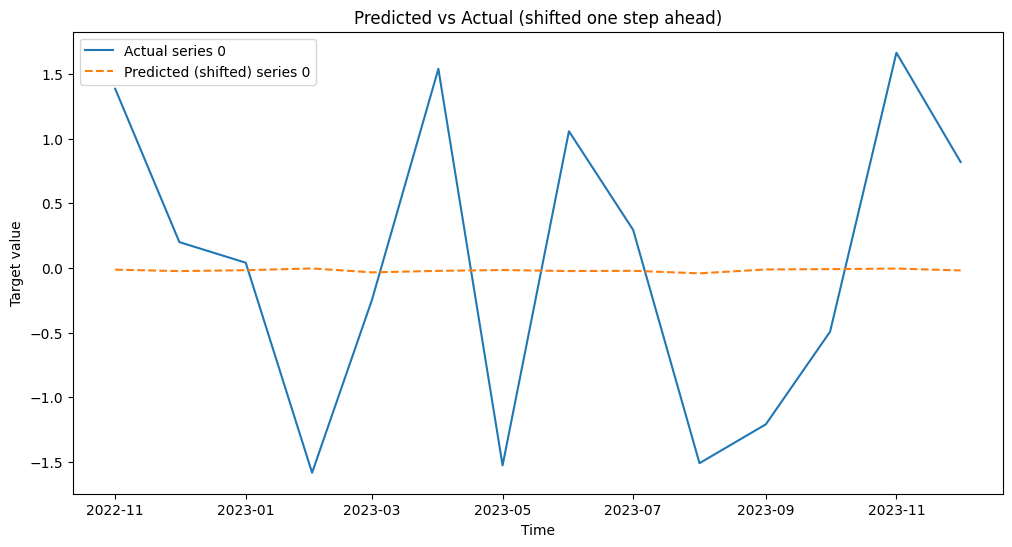

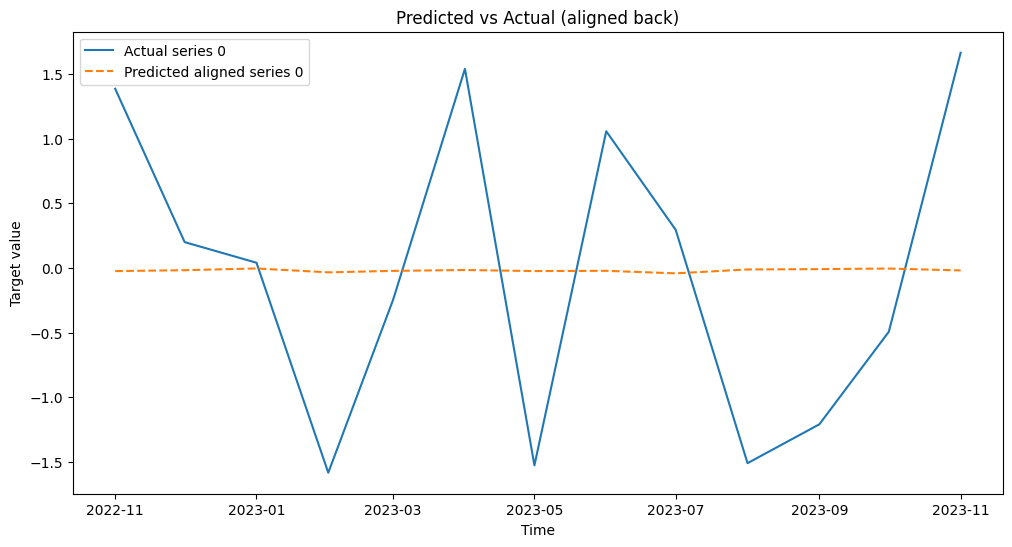

In [ ]:
# Instantiate engine
window_size = 50
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls", R=17, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=5
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

Parallel preds: 100%|██████████| 14/14 [00:30<00:00,  2.20s/it]


Overall metrics:
mse: 1.0273
r2: -0.0033
directional_accuracy: 0.5225


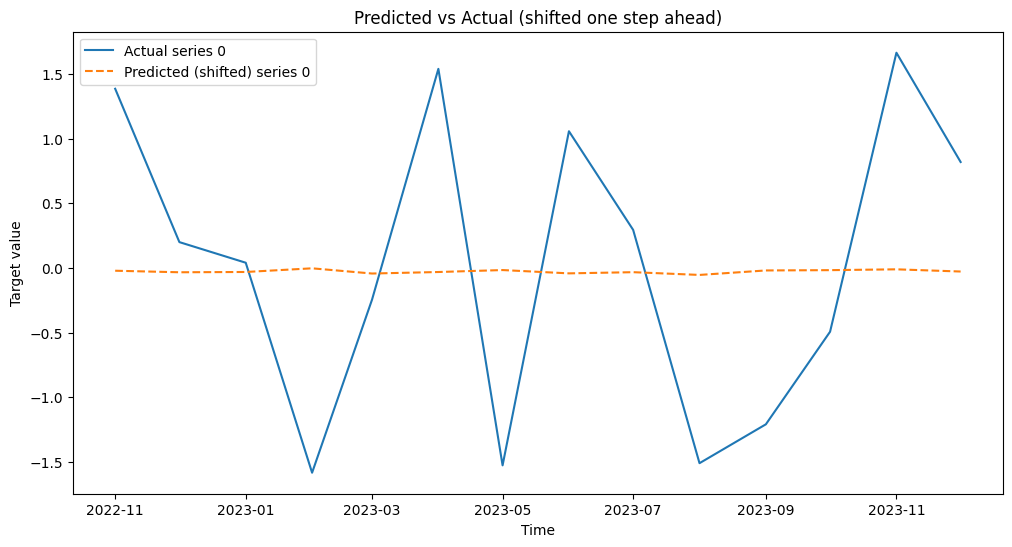

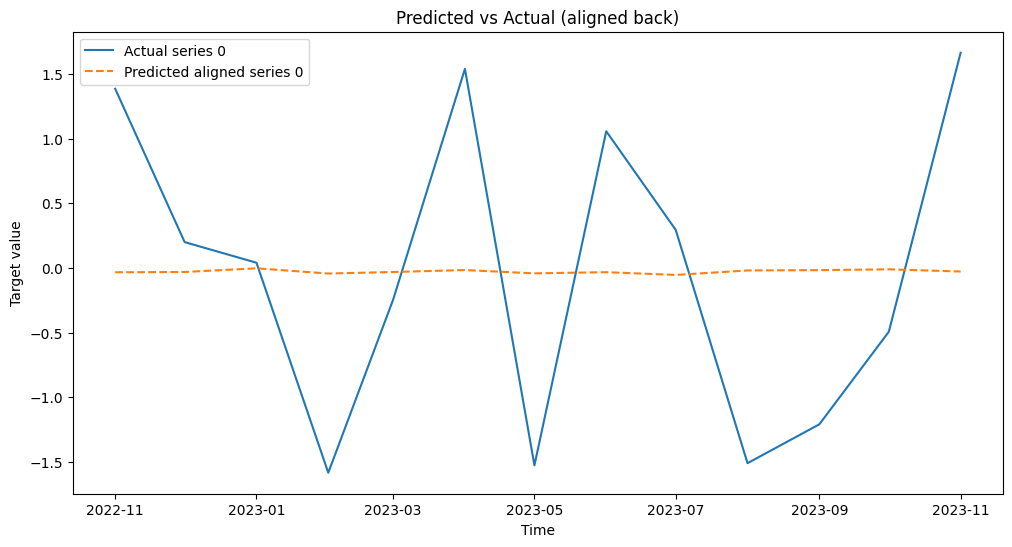

In [ ]:
# Instantiate engine
window_size = 50
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls", R=25, Ln=(20, 20), epsilon=1e-7, verbose=True, n_jobs=5
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

Parallel preds: 100%|██████████| 28/28 [00:55<00:00,  1.98s/it]


Overall metrics:
mse: 1.2024
r2: -0.0017
directional_accuracy: 0.5202


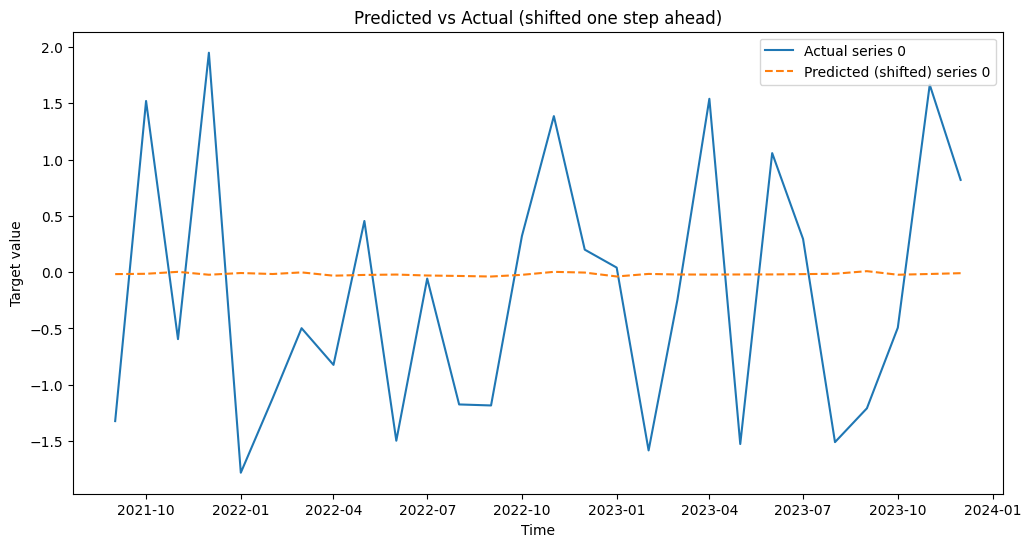

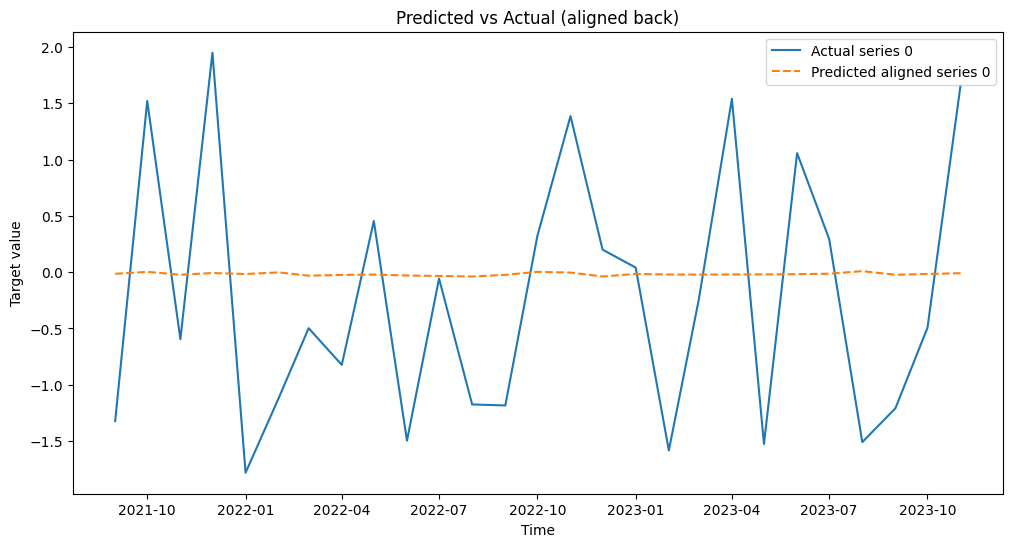

In [ ]:
# Instantiate engine
window_size = 50
train_start = int(0.9 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_ridge", R=25, Ln=(20, 20), epsilon=1e-7, verbose=True, n_jobs=5
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

Parallel preds: 100%|██████████| 195/195 [07:49<00:00,  2.41s/it]


Overall metrics:
mse: 1.0448
r2: -0.0071
directional_accuracy: 0.5132


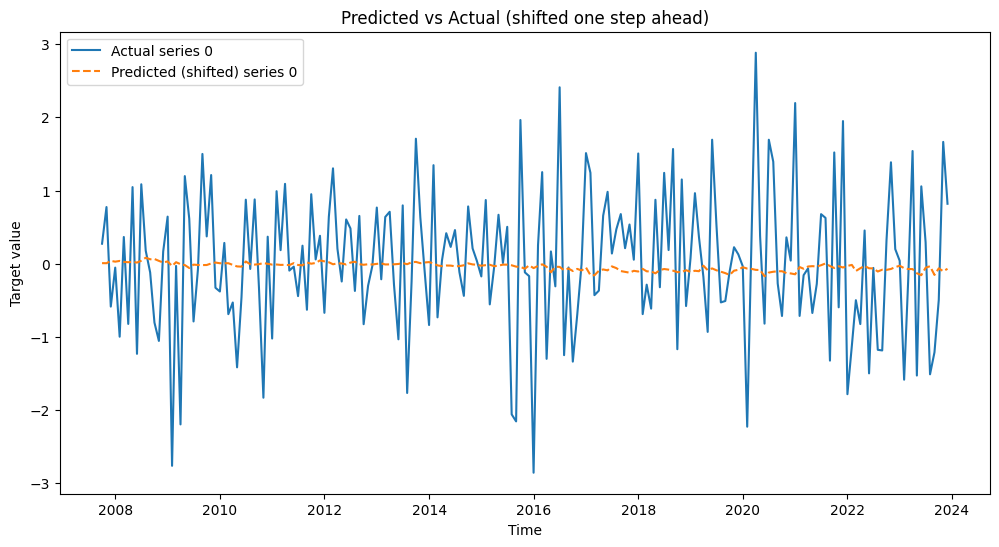

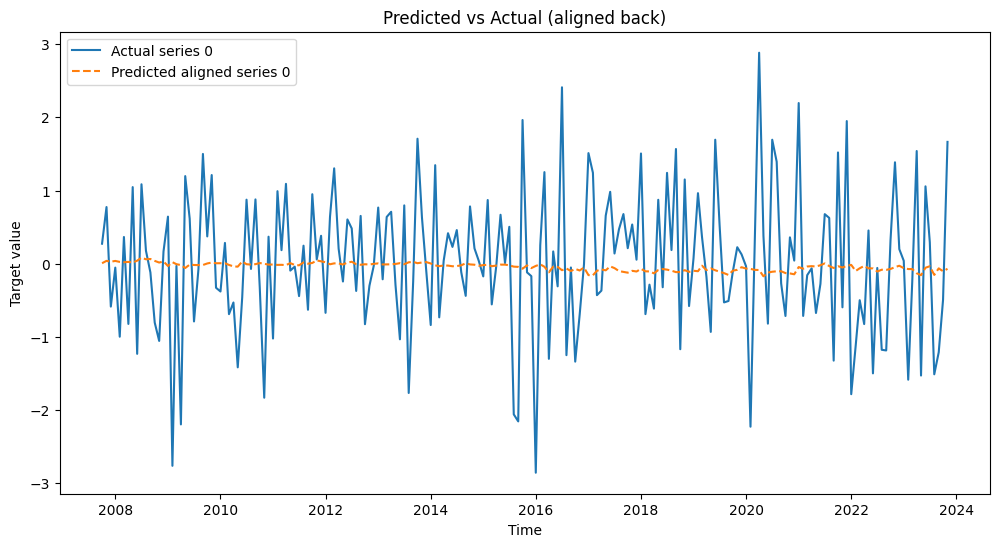

In [ ]:
from model.prediction_engine import PredictionTestEngine
# Instantiate engine
window_size = 80
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    # train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_ridge", R=30, Ln=(4, 4), epsilon=1e-8, verbose=True, n_jobs=5
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

Overall metrics:
mse: 1.0411
r2: -0.0035
directional_accuracy: 0.5297


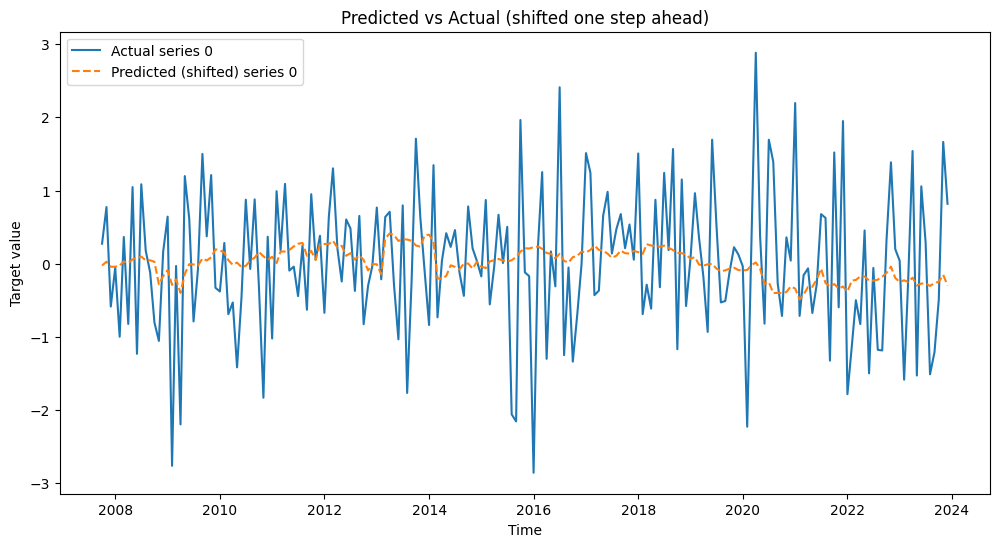

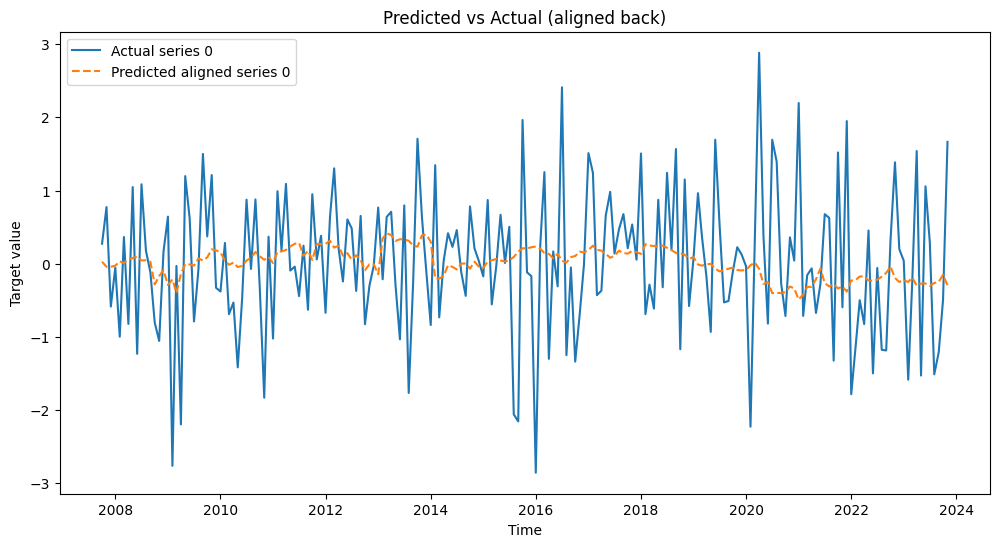

In [ ]:
# Instantiate engine
window_size = 80
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all, Y_all,
    window_size=window_size,
    # train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="ridge", alpha=1.0
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

# Grid Search

Running grid search with 150 combinations...
Combination 1/150: window_size=50, R=10, Ln=(2, 2)
  MSE: 1.004122, R2: -0.009890, Directional Accuracy: 0.520997
Combination 2/150: window_size=50, R=10, Ln=(4, 4)
  MSE: 1.000987, R2: -0.006738, Directional Accuracy: 0.524934
Combination 3/150: window_size=50, R=10, Ln=(8, 8)
  MSE: 0.998692, R2: -0.004429, Directional Accuracy: 0.454068
Combination 4/150: window_size=50, R=10, Ln=(15, 15)
  MSE: 0.998413, R2: -0.004148, Directional Accuracy: 0.494751
Combination 5/150: window_size=50, R=10, Ln=(20, 20)
  MSE: 0.997319, R2: -0.003048, Directional Accuracy: 0.463255
Combination 6/150: window_size=50, R=20, Ln=(2, 2)
  MSE: 0.983161, R2: 0.011191, Directional Accuracy: 0.517060
Combination 7/150: window_size=50, R=20, Ln=(4, 4)
  MSE: 1.010977, R2: -0.016785, Directional Accuracy: 0.523622
Combination 8/150: window_size=50, R=20, Ln=(8, 8)
  MSE: 0.996214, R2: -0.001937, Directional Accuracy: 0.515748
Combination 9/150: window_size=50, R=20,

,window_size,R,Ln,mse,r2,directional_accuracy
13,50,30,"(15, 15)",0.994782,-0.000497,0.586614
8,50,20,"(15, 15)",0.994730,-0.000444,0.577428
83,70,60,"(15, 15)",0.991419,0.002886,0.576115
69,70,20,"(20, 20)",0.992314,0.001985,0.573491
78,70,40,"(15, 15)",0.992855,0.001442,0.564304
74,70,30,"(20, 20)",0.993413,0.000880,0.559055
88,70,80,"(15, 15)",0.988886,0.005433,0.547244
127,100,20,"(8, 8)",0.994602,-0.000316,0.545932
124,100,10,"(20, 20)",0.994282,0.000006,0.544619
20,50,60,"(2, 2)",1.008812,-0.014608,0.544619


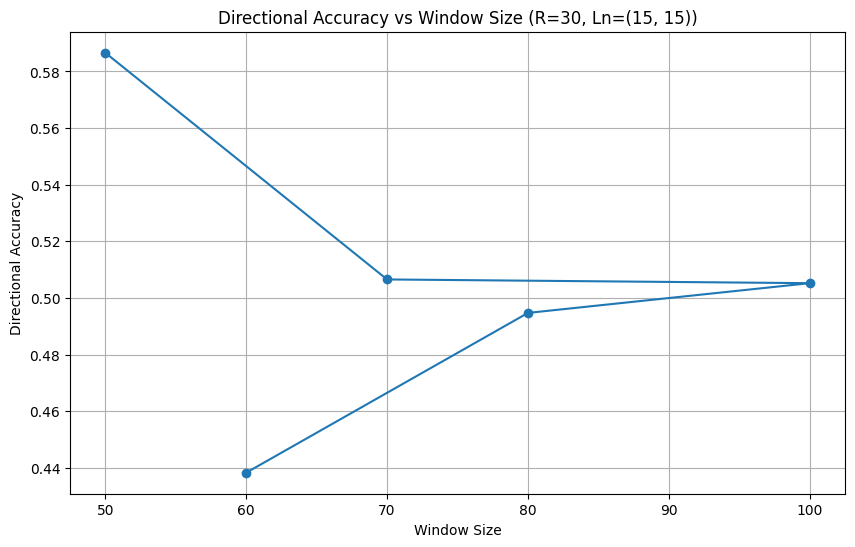

In [ ]:
import json
import pandas as pd
import numpy as np
from time import time
from itertools import product
from model.prediction_engine import PredictionTestEngine
from datetime import datetime
from matplotlib import pyplot as plt

# Define hyperparameter grid
window_sizes = [50, 60, 70, 80, 100]
R_values = [10, 20, 30, 40, 60, 80]
Ln_values = [(2,2), (4,4), (8,8), (15,15), (20,20)]

# Prepare to store results
results = []
epsilon = 1e-8  # Fixed epsilon value
n_jobs = 5     # Use 5 parallel jobs for each model fit

# Start timing
start_time = time()

# Total number of combinations to try
total_combinations = len(window_sizes) * len(R_values) * len(Ln_values)
print(f"Running grid search with {total_combinations} combinations...")

# Counter for progress tracking
counter = 0

# Try all combinations
for window_size, R, Ln in product(window_sizes, R_values, Ln_values):
    counter += 1
    print(f"Combination {counter}/{total_combinations}: window_size={window_size}, R={R}, Ln={Ln}")
    
    # Create a new engine for each window size
    engine = PredictionTestEngine(
        X_all,
        Y_all,
        window_size=window_size,
        train_start=int(0.98 * X_all.shape[0]),  # 95% of data for training
        time_index=time_index_all,
    )
    
    try:
        # Run the model with the current hyperparameters
        _, _, _, metrics = engine.run_window(
            method="hopls_ridge", 
            R=R, 
            Ln=Ln, 
            epsilon=epsilon, 
            verbose=False,  # Set to True if you want progress bars
            n_jobs=n_jobs
        )
        
        # Store the results
        result = {
            'window_size': window_size,
            'R': R,
            'Ln': Ln,
            'mse': metrics['mse'],
            'r2': metrics['r2'],
            'directional_accuracy': metrics['directional_accuracy']
        }
        results.append(result)
        
        # Print current result
        print(f"  MSE: {metrics['mse']:.6f}, R2: {metrics['r2']:.6f}, "
              f"Directional Accuracy: {metrics['directional_accuracy']:.6f}")
        
    except Exception as e:
        print(f"Error with window_size={window_size}, R={R}, Ln={Ln}: {e}")
        # Continue with next combination

# Calculate total elapsed time
elapsed_time = time() - start_time
print(f"Grid search completed in {elapsed_time:.2f} seconds.")

# Convert results to DataFrame and sort by directional accuracy (descending)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('directional_accuracy', ascending=False)

# Save results to JSON
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_filename = f"hopls_ridge_gridsearch_results_{timestamp}.json"
with open(json_filename, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to {json_filename}")

# Print top 10 configurations by directional accuracy
print("\nTop 10 configurations by directional accuracy:")
pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)
display(results_df.head(10))

# Plot directional accuracy vs window size for the top R and Ln combination
best_R = results_df.iloc[0]['R']
best_Ln = results_df.iloc[0]['Ln']
best_configs = results_df[(results_df['R'] == best_R) & 
                         (results_df['Ln'] == results_df.iloc[0]['Ln'])]

plt.figure(figsize=(10, 6))
plt.plot(best_configs['window_size'], best_configs['directional_accuracy'], 'o-')
plt.title(f'Directional Accuracy vs Window Size (R={best_R}, Ln={best_Ln})')
plt.xlabel('Window Size')
plt.ylabel('Directional Accuracy')
plt.grid(True)
plt.show()

Rolling prediction:   0%|          | 0/225 [00:00<?, ?it/s]

/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  Y_pred.reshape(Y_pred.shape[0], -1)
Rolling prediction: 100%|██████████| 225/225 [15:26<00:00,  4.12s/it]


Overall metrics:
mse: 0.9805
r2: -0.0021
directional_accuracy: 0.4998


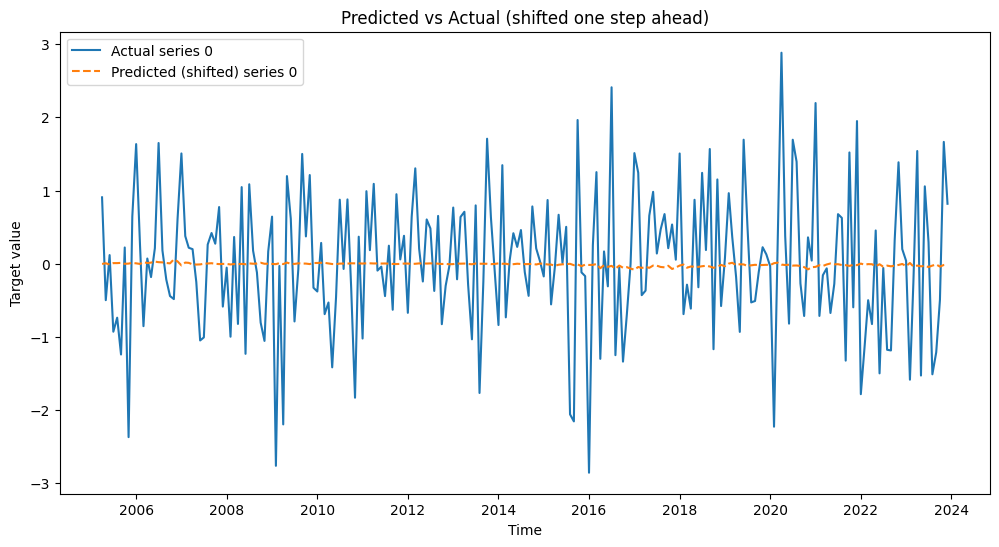

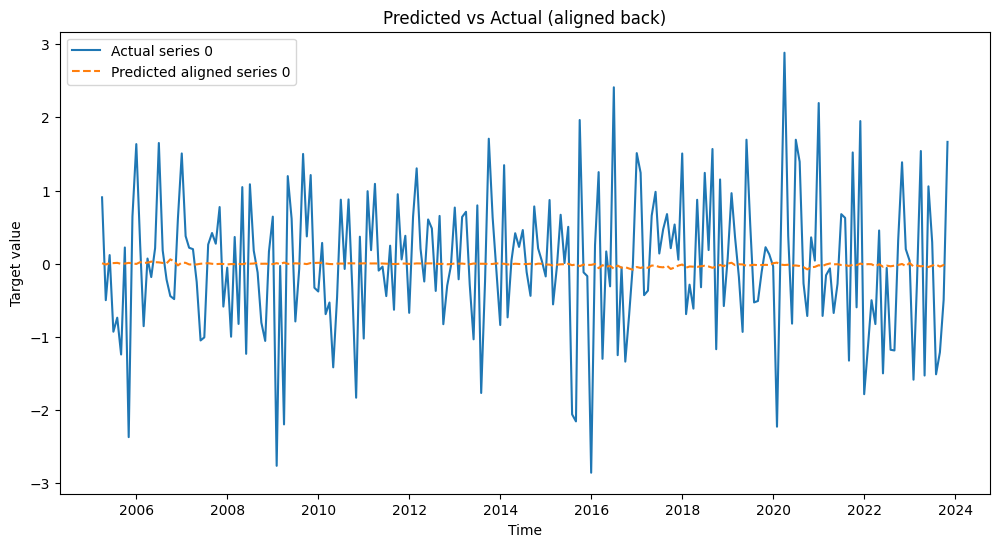

In [ ]:
from model.prediction_engine import PredictionTestEngine
# Instantiate engine
window_size = 50
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    # train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls", R=20, Ln=(15, 15), epsilon=1e-8, verbose=True, n_jobs=1
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

In [ ]:
import json
import pandas as pd
import numpy as np
from time import time
from itertools import product
from model.prediction_engine import PredictionTestEngine
from datetime import datetime
from matplotlib import pyplot as plt

# Define hyperparameter grid
window_sizes = [50, 60, 70, 80, 100]
R_values = [10, 20, 30, 40, 60, 80]
Ln_values = [(2,2), (4,4), (8,8), (15,15), (20,20)]

# Prepare to store results
results = []
epsilon = 1e-8  # Fixed epsilon value
n_jobs = 5     # Use 5 parallel jobs for each model fit

# Start timing
start_time = time()

# Total number of combinations to try
total_combinations = len(window_sizes) * len(R_values) * len(Ln_values)
print(f"Running grid search with {total_combinations} combinations...")

# Counter for progress tracking
counter = 0

# Try all combinations
for window_size, R, Ln in product(window_sizes, R_values, Ln_values):
    counter += 1
    print(f"Combination {counter}/{total_combinations}: window_size={window_size}, R={R}, Ln={Ln}")
    
    # Create a new engine for each window size
    engine = PredictionTestEngine(
        X_all,
        Y_all,
        window_size=window_size,
        # train_start=int(0.98 * X_all.shape[0]),  # 95% of data for training
        time_index=time_index_all,
    )
    
    try:
        # Run the model with the current hyperparameters
        _, _, _, metrics = engine.run_window(
            method="hopls", 
            R=R, 
            Ln=Ln, 
            epsilon=epsilon, 
            verbose=False,  # Set to True if you want progress bars
            n_jobs=n_jobs
        )
        
        # Store the results
        result = {
            'window_size': window_size,
            'R': R,
            'Ln': Ln,
            'mse': metrics['mse'],
            'r2': metrics['r2'],
            'directional_accuracy': metrics['directional_accuracy']
        }
        results.append(result)
        
        # Print current result
        print(f"  MSE: {metrics['mse']:.6f}, R2: {metrics['r2']:.6f}, "
              f"Directional Accuracy: {metrics['directional_accuracy']:.6f}")
        
    except Exception as e:
        print(f"Error with window_size={window_size}, R={R}, Ln={Ln}: {e}")
        # Continue with next combination

# Calculate total elapsed time
elapsed_time = time() - start_time
print(f"Grid search completed in {elapsed_time:.2f} seconds.")

# Convert results to DataFrame and sort by directional accuracy (descending)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('directional_accuracy', ascending=False)

# Save results to JSON
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_filename = f"hopls_ridge_gridsearch_results_{timestamp}.json"
with open(json_filename, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to {json_filename}")

# Print top 10 configurations by directional accuracy
print("\nTop 10 configurations by directional accuracy:")
pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)
display(results_df.head(10))

# Plot directional accuracy vs window size for the top R and Ln combination
best_R = results_df.iloc[0]['R']
best_Ln = results_df.iloc[0]['Ln']
best_configs = results_df[(results_df['R'] == best_R) & 
                         (results_df['Ln'] == results_df.iloc[0]['Ln'])]

plt.figure(figsize=(10, 6))
plt.plot(best_configs['window_size'], best_configs['directional_accuracy'], 'o-')
plt.title(f'Directional Accuracy vs Window Size (R={best_R}, Ln={best_Ln})')
plt.xlabel('Window Size')
plt.ylabel('Directional Accuracy')
plt.grid(True)
plt.show()

Running grid search with 150 combinations...
Combination 1/150: window_size=50, R=10, Ln=(2, 2)
  MSE: 0.980444, R2: -0.002077, Directional Accuracy: 0.507402
Combination 2/150: window_size=50, R=10, Ln=(4, 4)
  MSE: 0.980333, R2: -0.001964, Directional Accuracy: 0.505827
Combination 3/150: window_size=50, R=10, Ln=(8, 8)
  MSE: 0.979101, R2: -0.000705, Directional Accuracy: 0.514891
Combination 4/150: window_size=50, R=10, Ln=(15, 15)
  MSE: 0.978659, R2: -0.000253, Directional Accuracy: 0.500472
Combination 5/150: window_size=50, R=10, Ln=(20, 20)
  MSE: 0.978436, R2: -0.000025, Directional Accuracy: 0.510621
Combination 6/150: window_size=50, R=20, Ln=(2, 2)
  MSE: 0.990582, R2: -0.012439, Directional Accuracy: 0.503972
Combination 7/150: window_size=50, R=20, Ln=(4, 4)
  MSE: 0.983438, R2: -0.005137, Directional Accuracy: 0.502257
Combination 8/150: window_size=50, R=20, Ln=(8, 8)
  MSE: 0.981806, R2: -0.003470, Directional Accuracy: 0.503342
Combination 9/150: window_size=50, R=20